In [26]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import h5py
from pylab import rcParams
rcParams['figure.figsize'] = 20,

In [3]:
pms = h5py.File('logs/predictions_default.h5', 'r')


In [42]:
pm=pms['pm'][7]
pm=pm.reshape((2,100,80,1))
pm=np.concatenate((pm[0].reshape((100,80)),pm[1].reshape((100,80))),axis = 1)
pm = np.stack((pm,)*3, axis=-1)

74


/tmp/ipykernel_5135/1930968025.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


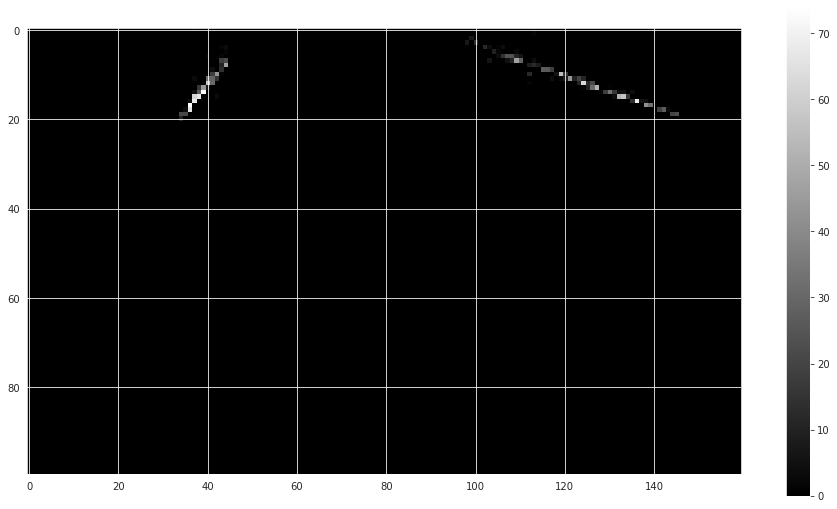

In [43]:
max=np.max(pm)
print(max)
pm= pm /max
plt.imshow(pm,cmap='gray',vmin=0, vmax=max)
plt.colorbar()
plt.show()
img = im.fromarray((pm * 255).astype(np.uint8))
img.save('pm.jpg')
